In [6]:
from torch import Tensor

import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import MultitaskGaussianLikelihood, Likelihood
from gpytorch.distributions import MultivariateNormal
from gpytorch.priors import GammaPrior
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

In [ ]:
# We will use the simplest form of GP model, exact inference
class FancyGPWithPriors(ExactGP):
    def __init__(self, train_X: Tensor, train_Y: Tensor, likelihood: Likelihood):
        
        super(FancyGPWithPriors, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        lengthscale_prior = GammaPrior(3.0, 6.0)
        outputscale_prior = GammaPrior(2.0, 0.15)

        self.covar_module = ScaleKernel(
            RBFKernel(lengthscale_prior=lengthscale_prior),
            outputscale_prior=outputscale_prior
        )

        # Initialize lengthscale and outputscale to mean of priors
        self.covar_module.base_kernel.lengthscale = lengthscale_prior.mean
        self.covar_module.outputscale = outputscale_prior.mean
        
        self.to(train_X)

    def forward(self, x: Tensor) -> Tensor:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

likelihood = MultitaskGaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-2),
)

model = FancyGPWithPriors(train_x, train_y, likelihood)

In [8]:
from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import GammaPrior

class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API
    
    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [9]:
from botorch.fit import fit_gpytorch_model

def _get_and_fit_simple_custom_gp(Xs, Ys, **kwargs):
    model = SimpleCustomGP(Xs[0], Ys[0])
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

In [10]:
import random
import numpy as np

def branin(parameterization, *args):
    x1, x2 = parameterization["x1"], parameterization["x2"]
    y = (x2 - 5.1 / (4 * np.pi ** 2) * x1 ** 2 + 5 * x1 / np.pi - 6) ** 2
    y += 10 * (1 - 1 / (8 * np.pi)) * np.cos(x1) + 10
    # let's add some synthetic observation noise
    y += random.normalvariate(0, 0.1)
    return {"branin": (y, 0.0)}

In [11]:
from ax import ParameterType, RangeParameter, SearchSpace

search_space = SearchSpace(
    parameters=[
        RangeParameter(
            name="x1", parameter_type=ParameterType.FLOAT, lower=-5, upper=10
        ),
        RangeParameter(
            name="x2", parameter_type=ParameterType.FLOAT, lower=0, upper=15
        ),
    ]
)

In [12]:
from ax import SimpleExperiment

exp = SimpleExperiment(
    name="test_branin",
    search_space=search_space,
    evaluation_function=branin,
    objective_name="branin",
    minimize=True,
)

In [13]:
from ax.modelbridge import get_sobol

sobol = get_sobol(exp.search_space)
exp.new_batch_trial(generator_run=sobol.gen(5))

BatchTrial(experiment_name='test_branin', index=0, status=TrialStatus.CANDIDATE)

[INFO 01-26 13:14:38] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


Running optimization batch 1/5...


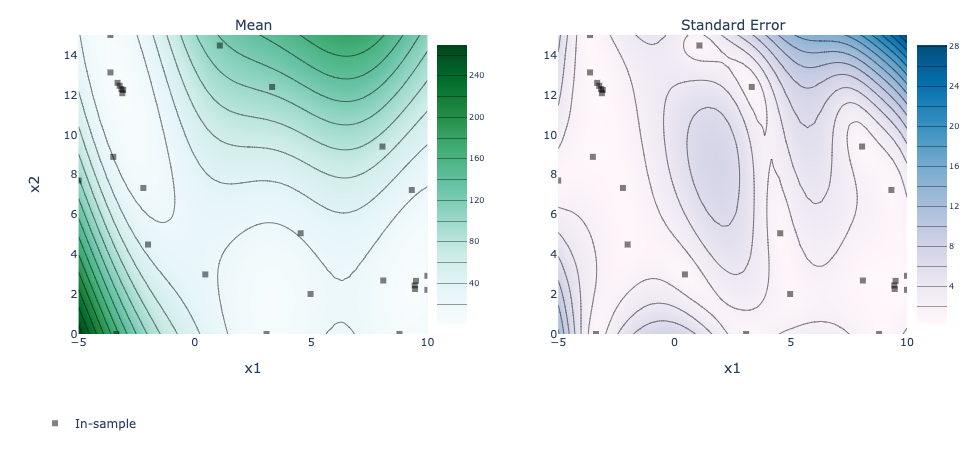

Running optimization batch 2/5...


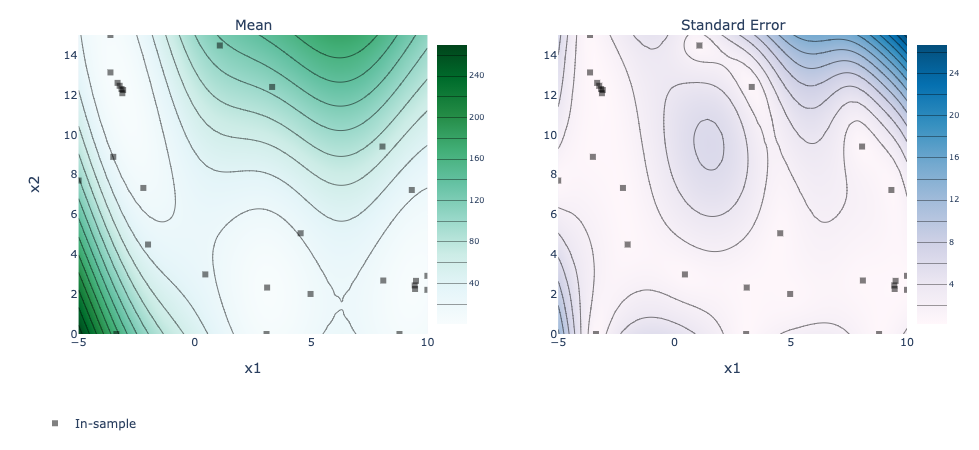

Running optimization batch 3/5...


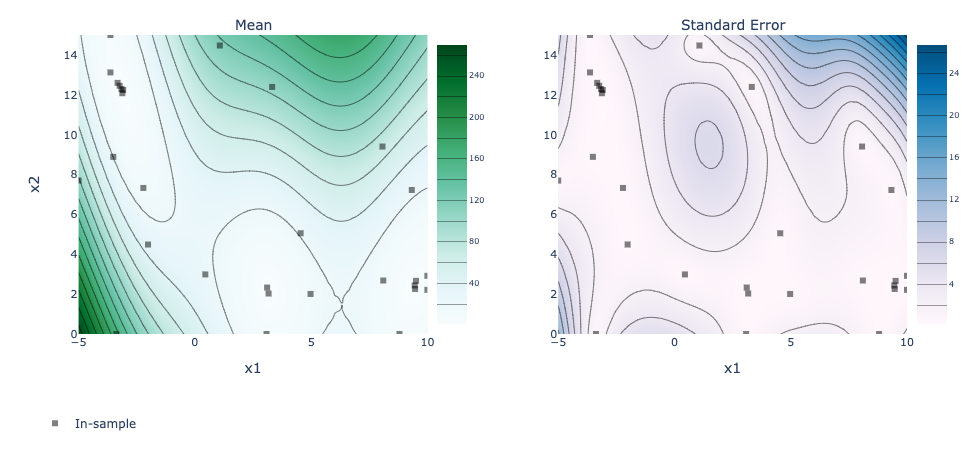

Running optimization batch 4/5...


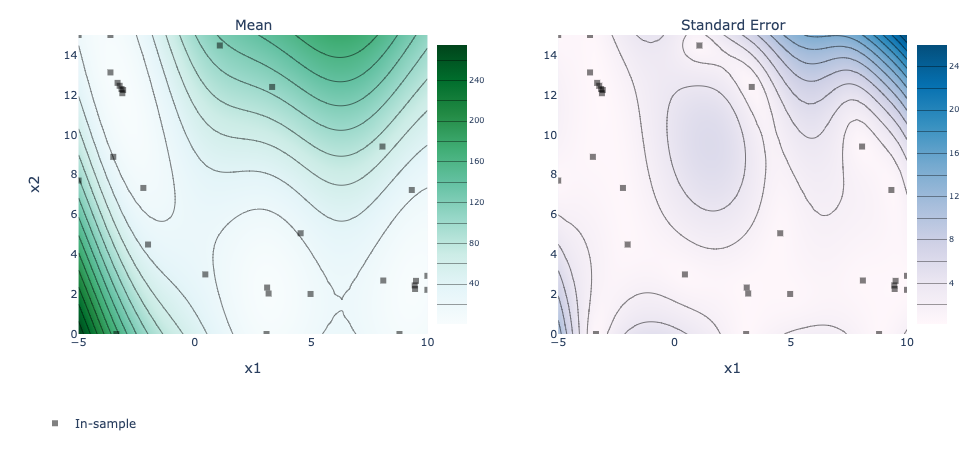

Running optimization batch 5/5...


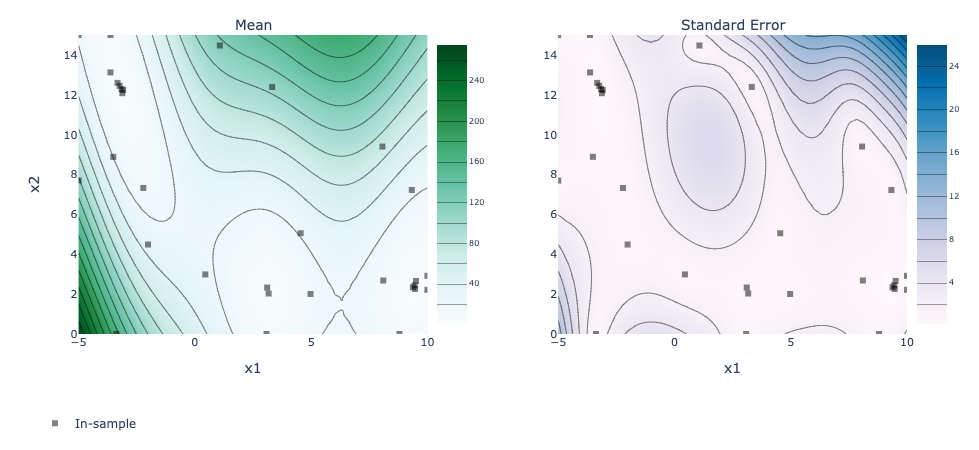

Done!


In [29]:
from ax.modelbridge.factory import get_botorch
from ax.plot.contour import plot_contour
from ax.utils.notebook.plotting import render, init_notebook_plotting
import matplotlib
%matplotlib inline

init_notebook_plotting()

for i in range(5):
    print(f"Running optimization batch {i+1}/5...")
    model = get_botorch(
        experiment=exp,
        data=exp.eval(),
        search_space=exp.search_space,
        model_constructor=_get_and_fit_simple_custom_gp,
    )
    batch = exp.new_trial(generator_run=model.gen(1))

    render(plot_contour(
        model=model,
        param_x='x1',
        param_y='x2',
        metric_name='branin',
    ))
    
print("Done!")

In [23]:
exp.eval().df

arm_name metric_name        mean  sem  trial_index
0      0_0      branin   13.187358  0.0            0
1      0_1      branin   69.304350  0.0            0
2      0_2      branin   33.244625  0.0            0
3      0_3      branin   19.500530  0.0            0
4      0_4      branin   23.866388  0.0            0
5      1_0      branin  105.778698  0.0            1
6      2_0      branin  165.729548  0.0            2
7      3_0      branin  115.215776  0.0            3
8      4_0      branin   24.148223  0.0            4
9      5_0      branin   21.515163  0.0            5